In [1]:
# useful imports
import numpy as np
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

cols = [c['color'] for c in matplotlib.rcParams['axes.prop_cycle']]

In [2]:
# GPflow imports
import gpflow

from gpflow.likelihoods import Gaussian, SwitchedLikelihood
from gpflow.kernels import Matern52, RBF, White
from gpflow.kernels.mo_kernels import SharedIndependentMok
from gpflow.mean_functions import Linear
from gpflow.utilities import set_trainable

gpflow.config.set_summary_fmt("notebook")
gpflow.config.set_default_float(np.float64)

In [3]:
# dgplib imports
from dgplib.layers import Layer
from dgplib.multiprocess_layers import ConcatinativeMultiprocessLayer
from dgplib.cascade import Sequential
from dgplib.specialized_kernels import SwitchedKernel
from dgplib.utilities import print_summary

from dgplib.dsdgp import DSDGP

In [4]:
Ns = 300
Xs = np.linspace(-12, 12, Ns)[:, None]
Ys1 = np.sinc(Xs)
Ys2 = np.sinc(Xs) + np.sinc(5-Xs) + np.sinc(5+Xs)
Xs_augmented = np.vstack((np.hstack((Xs, np.zeros_like(Xs))), np.hstack((Xs, np.ones_like(Xs)))))

N1, N2, M = 150, 100, 50
X1 = np.random.uniform(-10, 10, N1)[:, None]
X2 = np.random.uniform(-10, 10, N2)[:,None]
X2 = X2[np.logical_or((X2<-3), (X2>3))][:,None]
Z = np.random.uniform(-10, 10, M)[:, None]
Y1 = np.sinc(X1) + np.random.randn(*X1.shape)*1e-2
Y2 = np.sinc(X2) + np.sinc(5-X2) + np.sinc(5+X2) + np.random.randn(*X2.shape)*1e-2

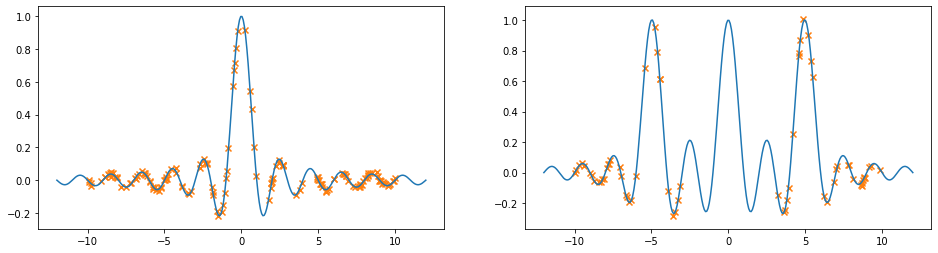

In [5]:
plt.figure(figsize=(16,9))
plt.subplot(221)
plt.plot(Xs, Ys1)
plt.scatter(X1, Y1, c=cols[1], marker='x')

plt.subplot(222)
plt.plot(Xs, Ys2)
plt.scatter(X2, Y2, c=cols[1], marker='x')

In [6]:
Z_augmented = np.vstack((np.hstack((Z, np.zeros_like(Z))), np.hstack((Z, np.ones_like(Z)))))
X_augmented = np.vstack((np.hstack((X1, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X2)))))
Y_augmented = np.vstack((np.hstack((Y1, np.zeros_like(X1))), np.hstack((Y2, np.ones_like(X2)))))

In [7]:
# Layers
def make_input_layer_kernels():
    shared_kernel = SharedIndependentMok(
        RBF(lengthscale=0.8, variance=1.) + White(variance=1e-5), output_dimensionality=1
    )
    task_kernels = [
        RBF(lengthscale=0.2, variance=2.1) + White(variance=1e-5),
        RBF(lengthscale=0.3, variance=2.2) + White(variance=1e-5)
    ]
    task_kernels = SharedIndependentMok(SwitchedKernel(task_kernels, 2), output_dimensionality=1)
    return [shared_kernel, task_kernels]

def make_output_layer_kernel():
    sub_kernels = [
        RBF(lengthscale=1.3, variance=1.) + White(variance=1e-5),
        RBF(lengthscale=1.4, variance=1.1) + White(variance=1e-5)
    ]
    kernel = SharedIndependentMok(
        SwitchedKernel(sub_kernels, 2),
        output_dimensionality=1
    )
    return kernel

input_layer = ConcatinativeMultiprocessLayer(
    input_dim=1,
    sublayer_output_dim=1,
    num_inducing=2 * M,
    kernels=make_input_layer_kernels(),
    fixed_linear_mean_function=True
)

output_layer = Layer(
    input_dim=2,
    output_dim=1,
    num_inducing=2 * M,
    kernel=make_output_layer_kernel()
)

In [8]:
seq = Sequential([input_layer, output_layer])

In [9]:
lik = SwitchedLikelihood([Gaussian(), Gaussian()])

In [10]:
model = DSDGP(Z=Z_augmented, layers=seq, likelihood=lik, multitask=True)

In [11]:
print_summary(model)

name,class,transform,trainable,shape,dtype,value
DSDGP.likelihood.likelihoods[0].variance,Parameter,Softplus,True,(),float64,1.0
DSDGP.likelihood.likelihoods[1].variance,Parameter,Softplus,True,(),float64,1.0
DSDGP.layers.constituents[0].sublayers[0].kernel.kernel.kernels[0].variance,Parameter,Softplus,True,(),float64,1.0
DSDGP.layers.constituents[0].sublayers[0].kernel.kernel.kernels[0].lengthscale,Parameter,Softplus,True,(),float64,0.800000011920929
DSDGP.layers.constituents[0].sublayers[0].kernel.kernel.kernels[1].variance,Parameter,Softplus,True,(),float64,9.999999747440792e-06
DSDGP.layers.constituents[0].sublayers[0].mean_function.A,Parameter,,True,"(1, 1)",float64,[[1.]]
DSDGP.layers.constituents[0].sublayers[0].mean_function.b,Parameter,,True,"(1,)",float64,[0.]
DSDGP.layers.constituents[0].sublayers[0].q_mu,Parameter,,True,"(100, 1)",float64,[[0....
DSDGP.layers.constituents[0].sublayers[0].q_sqrt,Parameter,FillTriangular,True,"(1, 100, 100)",float64,"[[[1., 0., 0...."
DSDGP.layers.constituents[0].sublayers[1].kernel.kernel.kernels[0].kernels[0].variance,Parameter,Softplus,True,(),float64,2.0999999046325684


In [12]:
model.initialize_layers_from_data(X_augmented)

Model Parameters Initialized


In [13]:
print_summary(model)

name,class,transform,trainable,shape,dtype,value
DSDGP.likelihood.likelihoods[0].variance,Parameter,Softplus,True,(),float64,1.0
DSDGP.likelihood.likelihoods[1].variance,Parameter,Softplus,True,(),float64,1.0
DSDGP.layers.constituents[0].sublayers[0].feature.features[0].Z,Parameter,,True,"(100, 2)",float64,"[[-9.88181722, 0...."
DSDGP.layers.constituents[0].sublayers[0].kernel.kernel.kernels[0].variance,Parameter,Softplus,True,(),float64,1.0
DSDGP.layers.constituents[0].sublayers[0].kernel.kernel.kernels[0].lengthscale,Parameter,Softplus,True,(),float64,0.800000011920929
DSDGP.layers.constituents[0].sublayers[0].kernel.kernel.kernels[1].variance,Parameter,Softplus,True,(),float64,9.999999747440792e-06
DSDGP.layers.constituents[0].sublayers[0].mean_function.A,Parameter,,False,"(2, 1)",float64,[[1.] [0.]]
DSDGP.layers.constituents[0].sublayers[0].mean_function.b,Parameter,,False,"(1,)",float64,[0.]
DSDGP.layers.constituents[0].sublayers[0].q_mu,Parameter,,True,"(100, 1)",float64,[[0....
DSDGP.layers.constituents[0].sublayers[0].q_sqrt,Parameter,FillTriangular,True,"(1, 100, 100)",float64,"[[[1., 0., 0...."


In [14]:
model.log_likelihood(X_augmented, Y_augmented, 1)

<tf.Tensor: id=2523, shape=(), dtype=float64, numpy=-313.26751600617064>

In [15]:
def log_likelihood_callback():
    return model.neg_log_marginal_likelihood(X_augmented, Y_augmented, num_samples=1)

In [16]:
opt = tf.optimizers.Adam(learning_rate=1e-2)
gpflow.utilities.training_loop(log_likelihood_callback, opt, model.trainable_variables, maxiter=1e3)

W0809 16:36:14.580498 140536594392896 deprecation.py:323] From /home/ayman/anaconda3/envs/multitask-gpflow-2.0a0/lib/python3.7/site-packages/tensorflow_core/python/ops/array_grad.py:502: _EagerTensorBase.cpu (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.identity instead.
W0809 16:36:14.697237 140536594392896 deprecation.py:323] From /home/ayman/anaconda3/envs/multitask-gpflow-2.0a0/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


In [17]:
model.log_likelihood(X_augmented, Y_augmented, 1)

<tf.Tensor: id=4951716, shape=(), dtype=float64, numpy=337.72136451580326>

/home/ayman/anaconda3/envs/multitask-gpflow-2.0a0/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/home/ayman/anaconda3/envs/multitask-gpflow-2.0a0/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/ayman/anaconda3/envs/multitask-gpflow-2.0a0/lib/python3.7/site-packages/ipykernel_launcher.py:15:

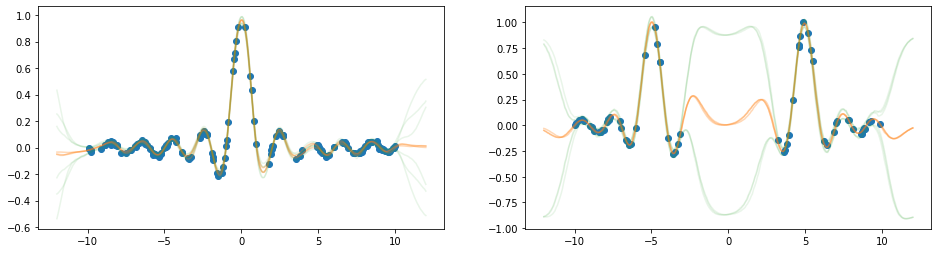

In [18]:
plt.figure(figsize=(16,9))
for _ in range(3):
    samples = model.predict_f(Xs_augmented, 1)
    sigma = np.diag(samples[1][0,0,:,:])
    plt.subplot(221)
    plt.plot(Xs_augmented[:Ns,0], samples[0][:,:Ns,0].numpy().reshape((Ns,)), color=cols[1], alpha=0.3)
    plt.plot(Xs_augmented[:Ns,0], samples[0][:,:Ns,0].numpy().reshape((Ns,))+2*np.sqrt(sigma)[:Ns], color=cols[2], alpha=0.1)
    plt.plot(Xs_augmented[:Ns,0], samples[0][:,:Ns,0].numpy().reshape((Ns,))-2*np.sqrt(sigma)[:Ns], color=cols[2], alpha=0.1)
    plt.subplot(222)
    plt.plot(Xs_augmented[Ns:,0], samples[0][:,Ns:,0].numpy().reshape((Ns,)), color=cols[1], alpha=0.3)
    plt.plot(Xs_augmented[Ns:,0], samples[0][:,Ns:,0].numpy().reshape((Ns,))+2*np.sqrt(sigma)[Ns:], color=cols[2], alpha=0.1)
    plt.plot(Xs_augmented[Ns:,0], samples[0][:,Ns:,0].numpy().reshape((Ns,))-2*np.sqrt(sigma)[Ns:], color=cols[2], alpha=0.1)

#plt.title('2 layer DGP')
plt.subplot(221)
plt.scatter(X1, Y1)
plt.subplot(222)
plt.scatter(X2, Y2)
plt.show()

/home/ayman/anaconda3/envs/multitask-gpflow-2.0a0/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/ayman/anaconda3/envs/multitask-gpflow-2.0a0/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


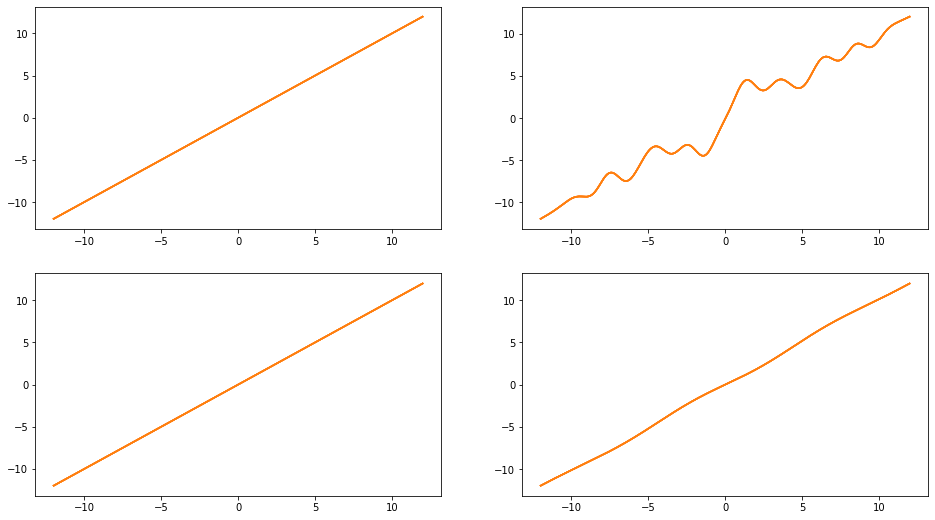

In [19]:
plt.figure(figsize=(16,9))
for _ in range(20):
    samples = model.predict_all_layers(Xs_augmented, full_cov=True, num_samples=1)
    for i in range(2):
        s = samples[1][0][0,:,i]
        plt.subplot(2, 2, i+1)
        plt.plot(Xs_augmented[:Ns,0], s[:Ns], color=cols[1], alpha=0.3)
        plt.subplot(2, 2, i+3)
        plt.plot(Xs_augmented[Ns:,0], s[Ns:], color=cols[1], alpha=0.3)

In [20]:
print_summary(model)

name,class,transform,trainable,shape,dtype,value
DSDGP.likelihood.likelihoods[0].variance,Parameter,Softplus,True,(),float64,0.00032125385359672225
DSDGP.likelihood.likelihoods[1].variance,Parameter,Softplus,True,(),float64,0.0008219559882079048
DSDGP.layers.constituents[0].sublayers[0].feature.features[0].Z,Parameter,,True,"(100, 2)",float64,"[[-1.06162195e+01, -5.92635572e-01..."
DSDGP.layers.constituents[0].sublayers[0].kernel.kernel.kernels[0].variance,Parameter,Softplus,True,(),float64,0.00247732980217349
DSDGP.layers.constituents[0].sublayers[0].kernel.kernel.kernels[0].lengthscale,Parameter,Softplus,True,(),float64,6.109535224367189
DSDGP.layers.constituents[0].sublayers[0].kernel.kernel.kernels[1].variance,Parameter,Softplus,True,(),float64,0.0003167635256223428
DSDGP.layers.constituents[0].sublayers[0].mean_function.A,Parameter,,False,"(2, 1)",float64,[[1.] [0.]]
DSDGP.layers.constituents[0].sublayers[0].mean_function.b,Parameter,,False,"(1,)",float64,[0.]
DSDGP.layers.constituents[0].sublayers[0].q_mu,Parameter,,True,"(100, 1)",float64,[[-5.08258073e-02...
DSDGP.layers.constituents[0].sublayers[0].q_sqrt,Parameter,FillTriangular,True,"(1, 100, 100)",float64,"[[[6.61847700e-01, 0.00000000e+00, 0.00000000e+00..."
